In [114]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from ggplot import *
from sys import float_info

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import json
import os
import random

import sys
sys.path.append("../..")
from networkentropy import network_energy as ne, network_energy_gradient as neg, networks

In [41]:
results = []
graphs = []
methods = ['graph', 'laplacian', 'randic']
generators = ['random', 'smallworld', 'waxman', 'powerlaw']
p_max = 4
p_values = list(range(1,p_max))

def create_graph(p, generator, p_max, num_nodes=100):
    if generator == 'random':
        return nx.erdos_renyi_graph(n=num_nodes, p=p/(p_max*10))
    elif generator == 'smallworld':
        return nx.watts_strogatz_graph(n=num_nodes, k=4, p=p/p_max)
    elif generator == 'waxman':
        return nx.waxman_graph(n=num_nodes, alpha=p/p_max, beta=0.1)
    elif generator == 'powerlaw':
        return nx.powerlaw_cluster_graph(n=num_nodes, m=3, p=p/(p_max*10))
    else:
        raise ValueError('Generator: {} does not exist'.format(generator))
        
p_values_generators = list(itertools.product(p_values, generators))
for p, generator in tqdm(p_values_generators):
    G = create_graph(p, generator, p_max)
    graphs.append((p, generator, G))
    for method in methods:
        graph_gradients = list(neg.get_energy_gradients(G, method).values())
        for gradient in graph_gradients:
            results.append((p, generator, method, gradient))
            
p, generator, method, gradients = map(list, zip(*results))
df = pd.DataFrame({'p': p, 'generator': generator, 'method': method, 'gradients': gradients})

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.59it/s]


### Visualization of energy gradients distributions in synthetic networks

Every network has been created with a few different parameters

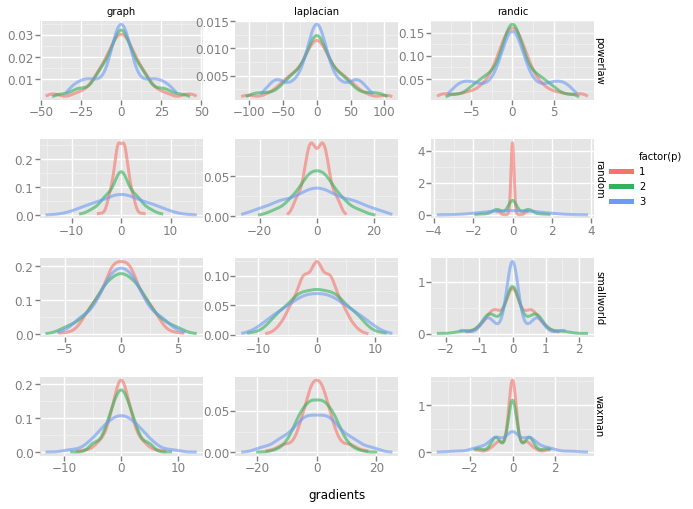

<ggplot: (97195319076)>

In [42]:
ggplot(aes(x='gradients', color='factor(p)'), data=df) + \
geom_density(alpha=0.6, size=3) + \
facet_grid('generator', 'method', scales = "free")

### Visualization of energy gradients distributions in empirical networks

Directed graphs have been chaged to undirected representation

In [43]:
networks_names = networks.__networks__.keys()
empirical_networks = {}
dir_name = '/tmp'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
for name in networks_names:
    #power grid and bisons url are broken
    if not name in ('power_grid', 'bisons'): 
        print("Leading network: {}".format(name))
        empirical_networks[name]  = networks.load_network(name).to_undirected()

Leading network: python_dependency
Leading network: R_dependency
Leading network: st_mark_ecosystem
Leading network: celegans
Leading network: cat_brain


In [56]:
results = []
for (name, G), method in itertools.product(empirical_networks.items(), methods):
    graph_gradients = list(neg.get_energy_gradients(G, method).values())
    for gradient in graph_gradients:
        results.append((name, method, gradient))

In [57]:
network, method, gradients = map(list, zip(*results))
df = pd.DataFrame({'network': network, 'method': method, 'gradients': gradients})

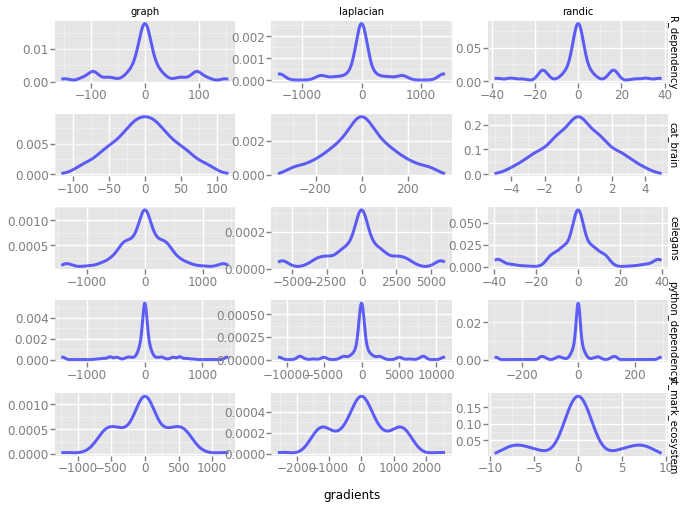

<ggplot: (-9223371939648870098)>

In [58]:
ggplot(aes(x='gradients'), data=df) + \
geom_density(alpha=0.6, color='blue', size=3) + \
facet_grid('network', 'method', scales = "free")

### Visualization of gradients

In [90]:
graphs_with_data = {}
min_energies = {}
max_energies = {}
min_gradients = {}
max_gradients = {}
for i, (p, generator, G) in enumerate(graphs):
    neg.get_graph_with_energy_data(G, methods=methods, copy=False)
    for method in methods:
        energies = np.array(list(nx.get_node_attributes(G, '{}_energy'.format(method)).values()))
        gradients = np.array([np.abs(g) for g in nx.get_edge_attributes(G, '{}_gradient'.format(method)).values()])
        graphs_with_data[(p, generator, method)] = (energies, gradients, G)
        min_energies[(p, generator, method)] = np.min(energies)
        max_energies[(p, generator, method)] = np.max(energies)
        min_gradients[(p, generator, method)] = np.min(gradients)
        max_gradients[(p, generator, method)] = np.max(gradients)
        
def get_vmin_vmax(min_dict, max_dict, vstrategy="", p=None, generator=None, method=None):
    strategies = vstrategy.split('+')
    vp_values, vmethods, vgenerators = p_values, methods, generators
    if 'p' in strategies:
        vp_values = [p]
    if 'method' in strategies:
        vmethods = [method]
    if 'generator' in strategies:
        vgenerators = [generator]

    min_value = float_info.max
    max_value = float_info.min
    for p, m, g in itertools.product(p_values, methods, generators):
        if p in vp_values and g in vgenerators and m in vmethods:
            if min_dict[(p, g, m)] < min_value:
                min_value = min_dict[(p, g, m)]
            if max_dict[(p, g, m)] > max_value:
                max_value = max_dict[(p, g, m)]
    return min_value, max_value

def get_vmin_vmax_energy(vstrategy, p, generator, mathod):
    return get_vmin_vmax(min_energies, max_energies, vstrategy, p, generator, mathod)

def get_vmin_vmax_gradient(vstrategy, p, generator, mathod):
    return get_vmin_vmax(min_gradients, max_gradients, vstrategy, p, generator, mathod)
            
def draw_network(p, generator, method, vstrategy=''):
    vmin, vmax = get_vmin_vmax_energy(vstrategy, p, generator, method)
    edge_vmin, edge_vmax = get_vmin_vmax_gradient(vstrategy, p, generator, method)
    energies, gradients, G = graphs_with_data[(p, generator, method)]
    pos = nx.layout.kamada_kawai_layout(G)
    plt.figure(figsize=(18,12))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=energies, cmap=plt.cm.coolwarm, 
                                   vmin=vmin, vmax=vmax, with_labels=False)
    edges = nx.draw_networkx_edges(G, pos, edge_vmin=edge_vmin, edge_vmax=edge_vmax, 
                                   edge_color=gradients, edge_cmap=plt.cm.Reds, width=2, with_labels=False)
    edges_cbar = plt.colorbar(edges)
    edges_cbar.ax.set_title('gradient')
    nodes_cbar = plt.colorbar(nodes)
    nodes_cbar.ax.set_title('energy')
    plt.title('Generator: {}, Method: {}, p: {}'.format(generator, method, p))
    plt.axis('off')
    plt.show()

### Visualization of graph energy and graph energy gradients in sythetic networks

Graphs for every energy computiong method share common colorbars. It can be easilty changed using parameter vstrategy.
For example value: `'p+method+genrator'` would result in separete colorbar for every plot
and value: `p+generator` would result in sharing colorbars between plots with same generator

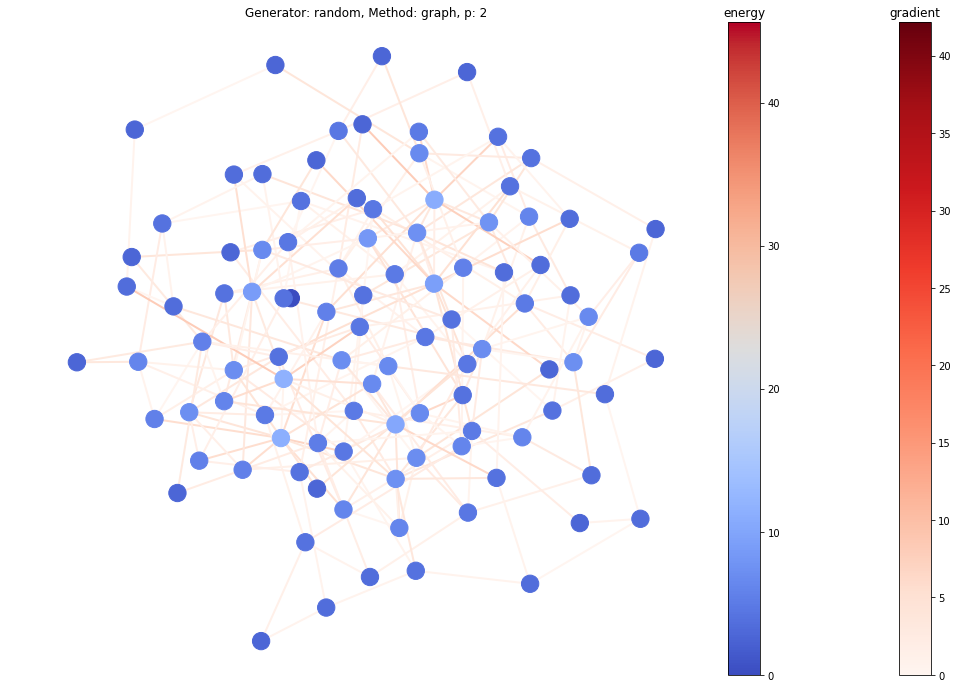

In [107]:
draw_network(2, 'random', 'graph', vstrategy='p+method')

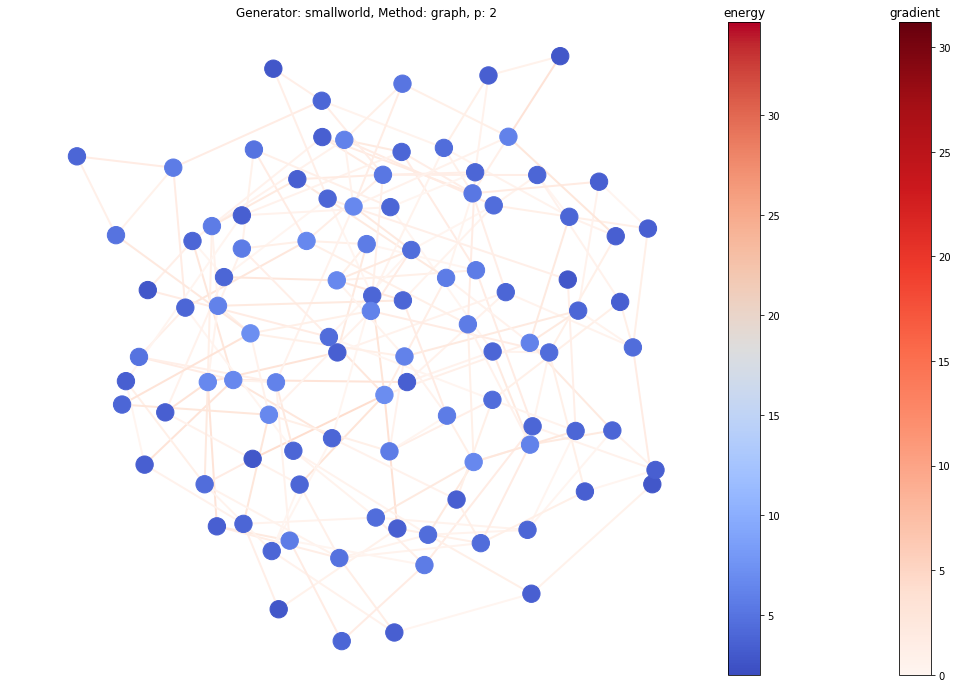

In [309]:
draw_network(2, 'smallworld', 'graph', vstrategy='p+method')

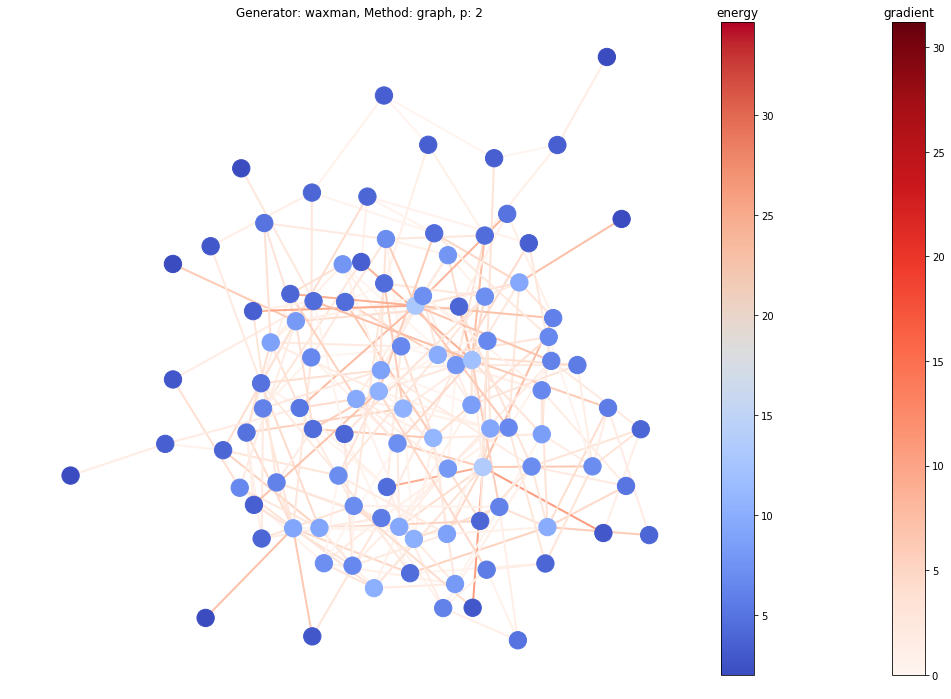

In [310]:
draw_network(2, 'waxman', 'graph', vstrategy='p+method')

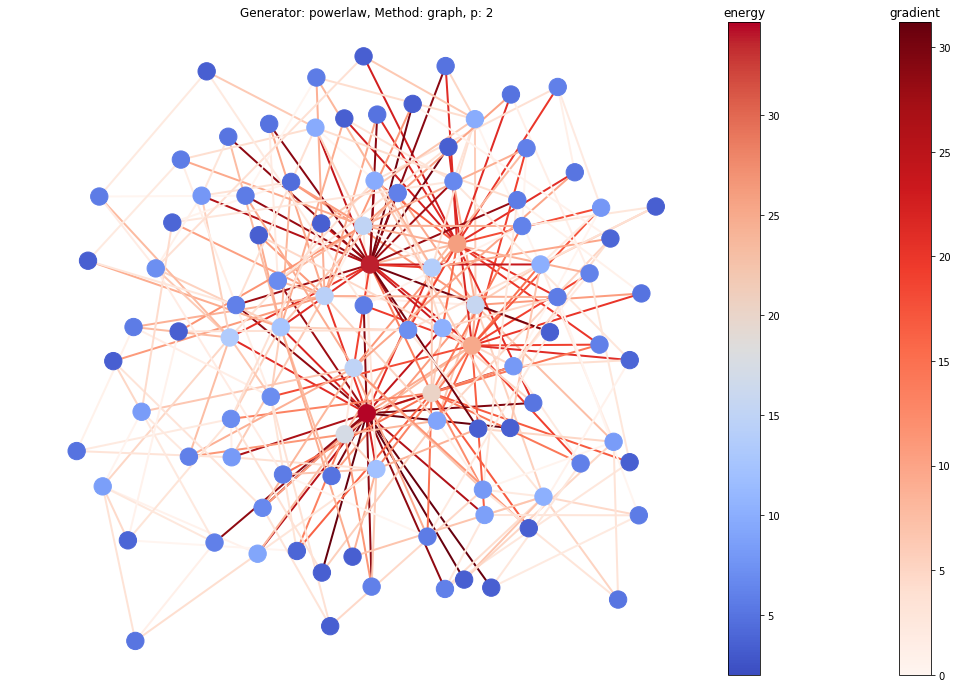

In [311]:
draw_network(2, 'powerlaw', 'graph', vstrategy='p+method')

### Visualization of laplacian energy and laplacian energy gradients in sythetic networks

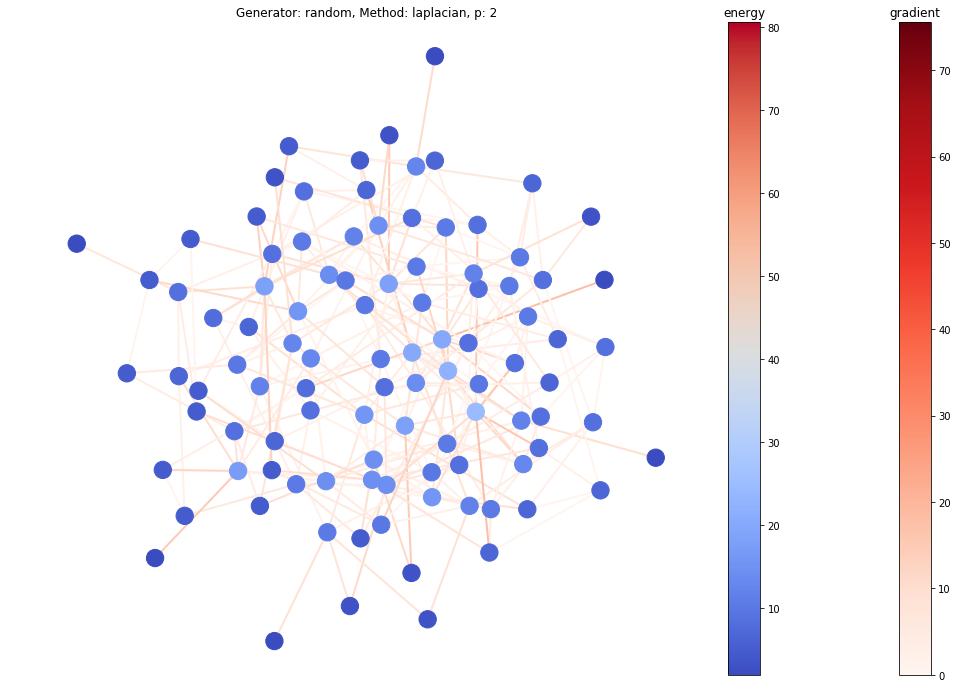

In [312]:
draw_network(2, 'random', 'laplacian', vstrategy='p+method')

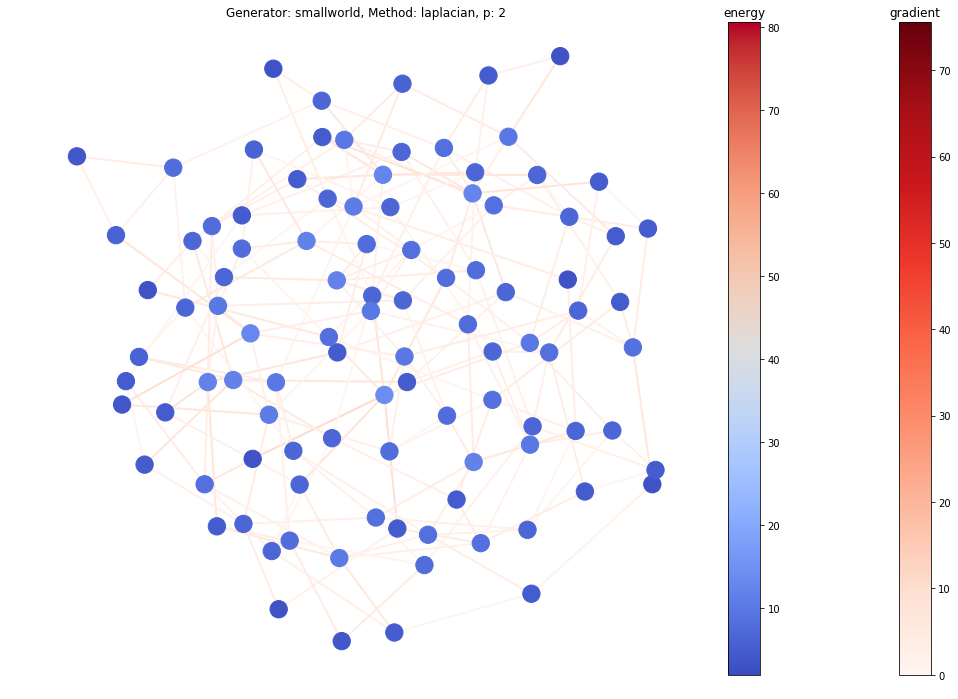

In [313]:
draw_network(2, 'smallworld', 'laplacian', vstrategy='p+method')

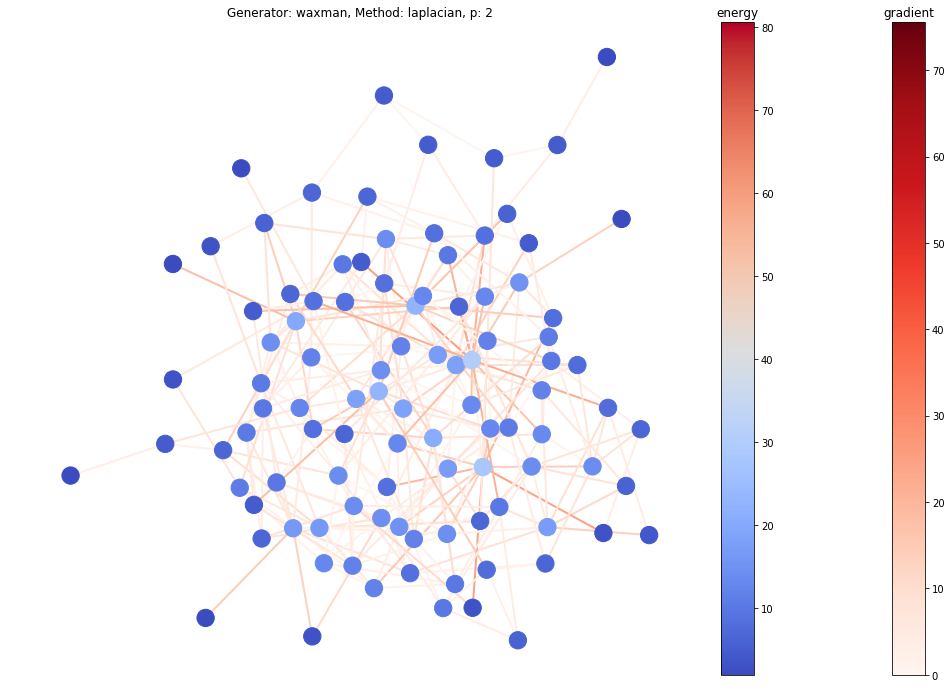

In [314]:
draw_network(2, 'waxman', 'laplacian', vstrategy='p+method')

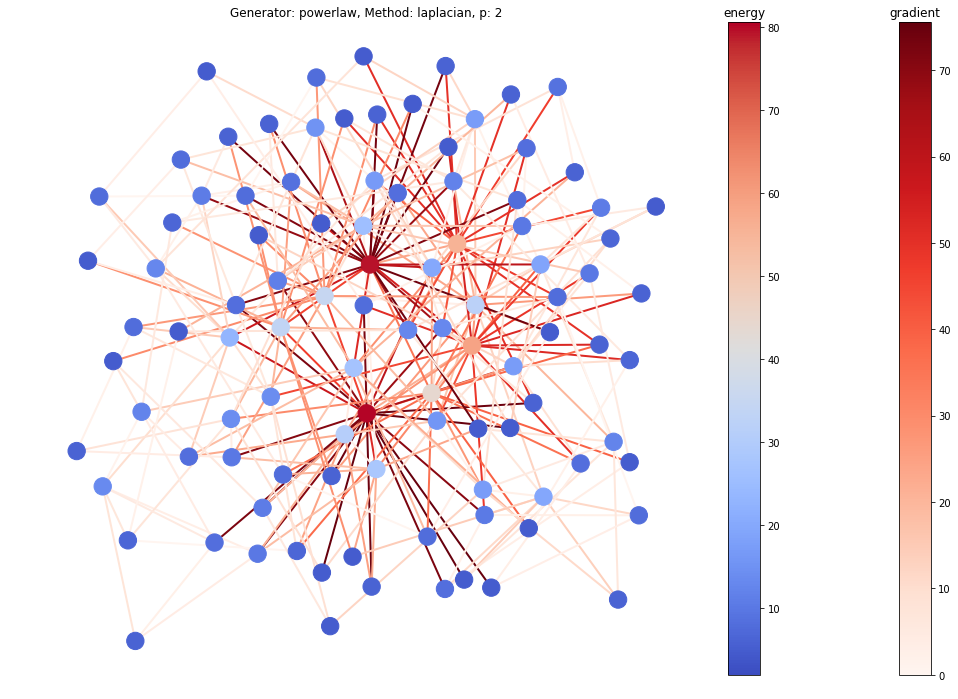

In [315]:
draw_network(2, 'powerlaw', 'laplacian', vstrategy='p+method')

### Visualization of laplacian energy and laplacian energy gradients in sythetic networks

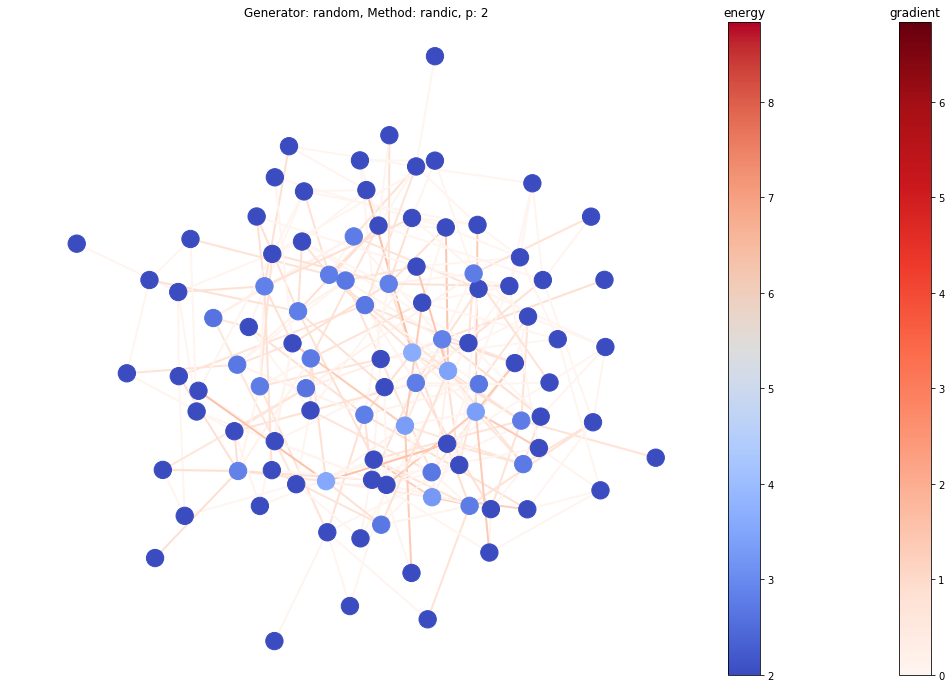

In [316]:
draw_network(2, 'random', 'randic', vstrategy='p+method')

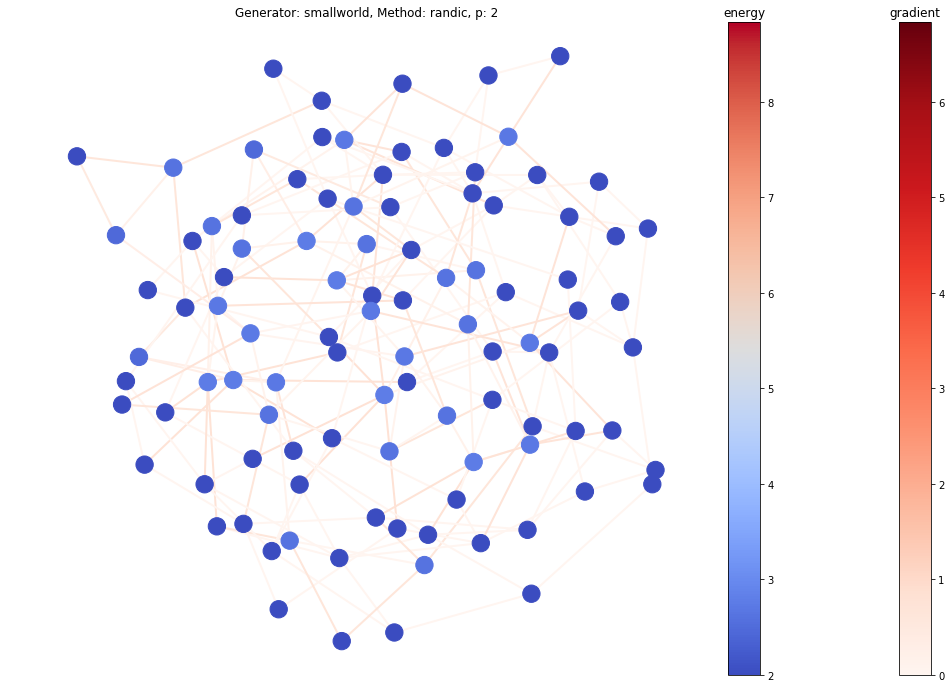

In [317]:
draw_network(2, 'smallworld', 'randic', vstrategy='p+method')

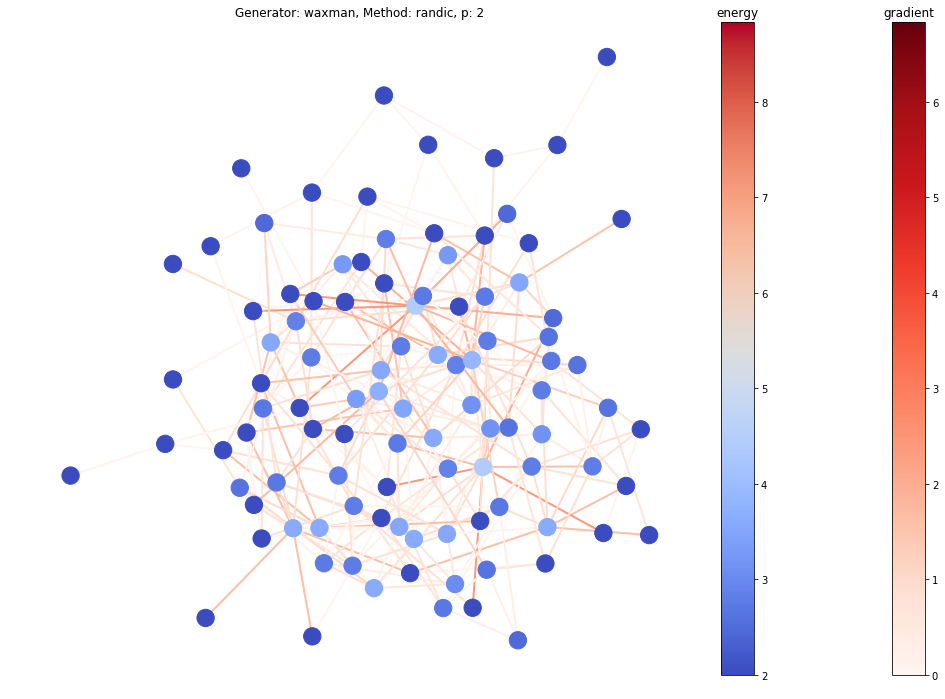

In [318]:
draw_network(2, 'waxman', 'randic', vstrategy='p+method')

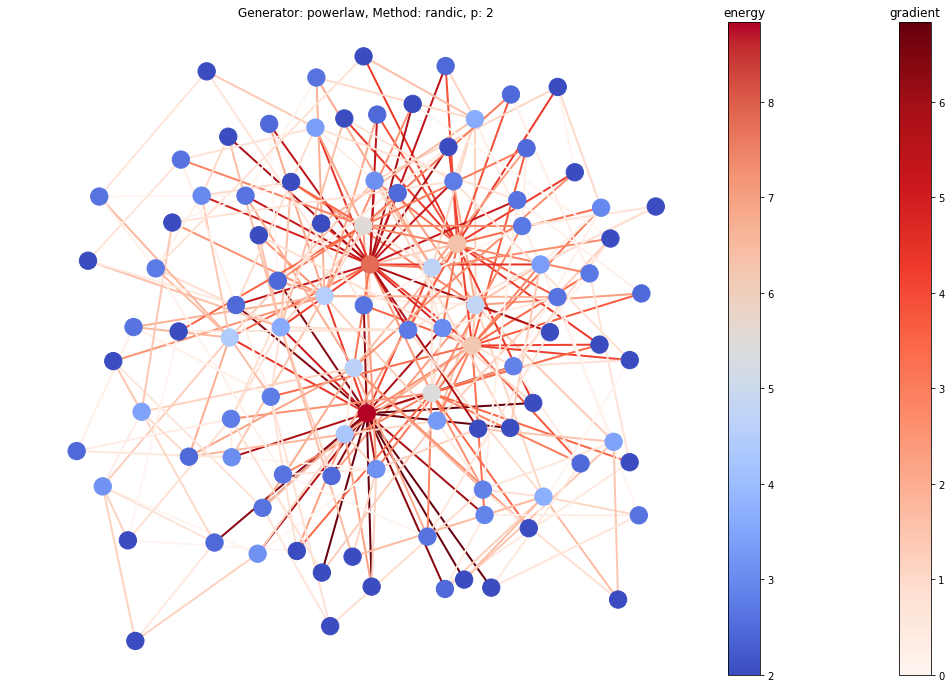

In [319]:
draw_network(2, 'powerlaw', 'randic', vstrategy='p+method')

### Visualization of gradients of empirical networks

Every graph has independent colorbar. It can be changes using parameter `vstrategy`

In [174]:
num_random_nodes=100
empirical_networks_with_data = {}
empirical_min_energies = {}
empirical_max_energies = {}
empirical_min_gradients = {}
empirical_max_gradients = {}

for network, G in empirical_networks.items():
    random_nodes = random.choices(list(G.nodes()), k=num_random_nodes)
    G = nx.Graph(G.subgraph(random_nodes))
    neg.get_graph_with_energy_data(G, methods=methods, copy=False)
    for method in methods:
        energies = np.array(list(nx.get_node_attributes(G, '{}_energy'.format(method)).values()))
        gradients = np.array([np.abs(g) for g in nx.get_edge_attributes(G, '{}_gradient'.format(method)).values()])
        empirical_networks_with_data[(network, method)] = (energies, gradients, G)
        empirical_min_energies[(network, method)] = np.min(energies)
        empirical_max_energies[(network, method)] = np.max(energies)
        empirical_min_gradients[(network, method)] = np.min(gradients)
        empirical_max_gradients[(network, method)] = np.max(gradients)
        
def empirical_get_vmin_vmax(min_dict, max_dict, vstrategy, network, method):
    strategies = vstrategy.split('+')
    empirical_networks_names = list(empirical_networks.keys())
    vnetworks, vmethods = empirical_networks_names, methods
    if 'network' in strategies:
        vnetworks = [network]
    if 'method' in strategies:
        vmethods = [method]
        
    min_value = float_info.max
    max_value = float_info.min
    for n, m in itertools.product(empirical_networks_names, methods):
        if n in vnetworks and m in vmethods:
            if min_dict[(n, m)] < min_value:
                min_value = min_dict[(n, m)]
            if max_dict[(n, m)] > max_value:
                max_value = max_dict[(n, m)]
    return min_value, max_value

def empirical_get_vmin_vmax_energy(vstrategy, network, method):
    return empirical_get_vmin_vmax(empirical_min_energies, empirical_max_energies, vstrategy, network, method)

def empirical_get_vmin_vmax_gradient(vstrategy,  network, method):
    return empirical_get_vmin_vmax(empirical_min_gradients, empirical_max_gradients, vstrategy, network, method)

def empirical_draw_network(network, method, vstrategy=''):
    vmin, vmax = empirical_get_vmin_vmax_energy(vstrategy, network, method)
    edge_vmin, edge_vmax = empirical_get_vmin_vmax_gradient(vstrategy, network, method)
    energies, gradients, G = empirical_networks_with_data[(network, method)]
    pos = nx.layout.kamada_kawai_layout(G)
    plt.figure(figsize=(18,12))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=energies, cmap=plt.cm.coolwarm, 
                                   vmin=vmin, vmax=vmax, with_labels=False)
    edges = nx.draw_networkx_edges(G, pos, edge_vmin=edge_vmin, edge_vmax=edge_vmax, 
                                   edge_color=gradients, edge_cmap=plt.cm.Reds, width=2, with_labels=False)
    edges_cbar = plt.colorbar(edges)
    edges_cbar.ax.set_title('gradient')
    nodes_cbar = plt.colorbar(nodes)
    nodes_cbar.ax.set_title('energy')
    plt.title('Network: {}, Method: {}'.format(network, method))
    plt.axis('off')
    plt.show()

In [175]:
empirical_networks.keys()

dict_keys(['python_dependency', 'R_dependency', 'st_mark_ecosystem', 'celegans', 'cat_brain'])

### Visualization of graph energies and graph gradients

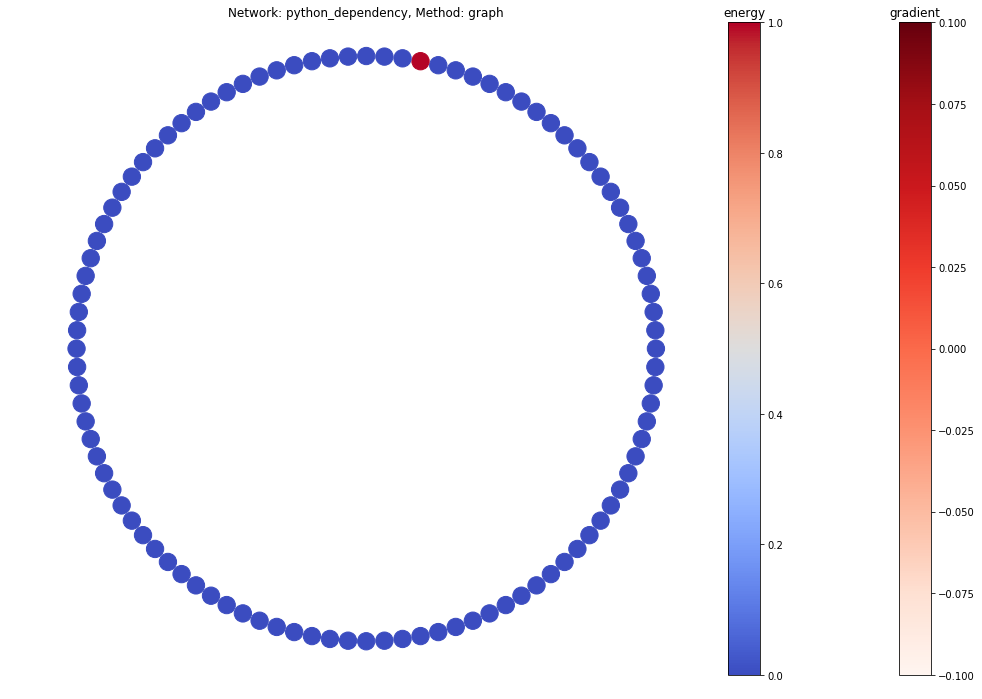

In [176]:
empirical_draw_network('python_dependency', 'graph', vstrategy='method+network')

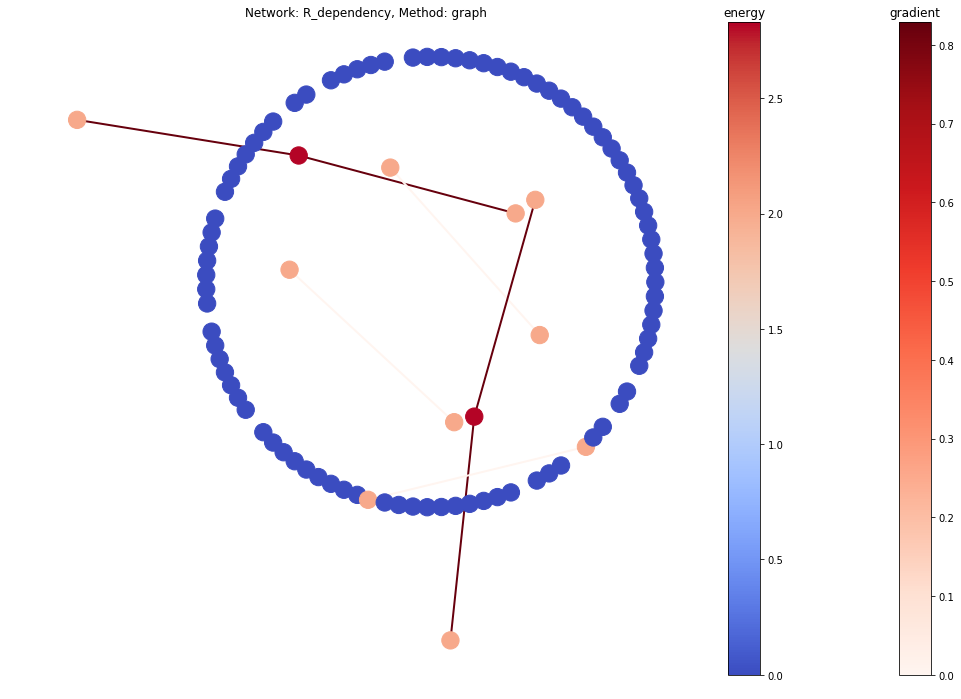

In [177]:
empirical_draw_network('R_dependency', 'graph', vstrategy='method+network')

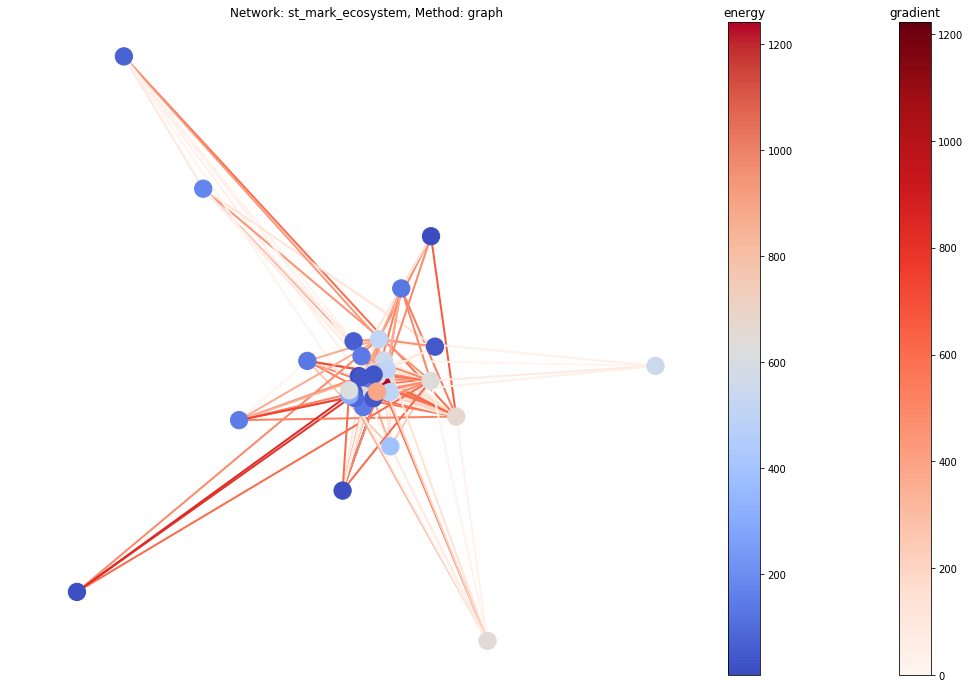

In [178]:
empirical_draw_network('st_mark_ecosystem', 'graph', vstrategy='method+network')

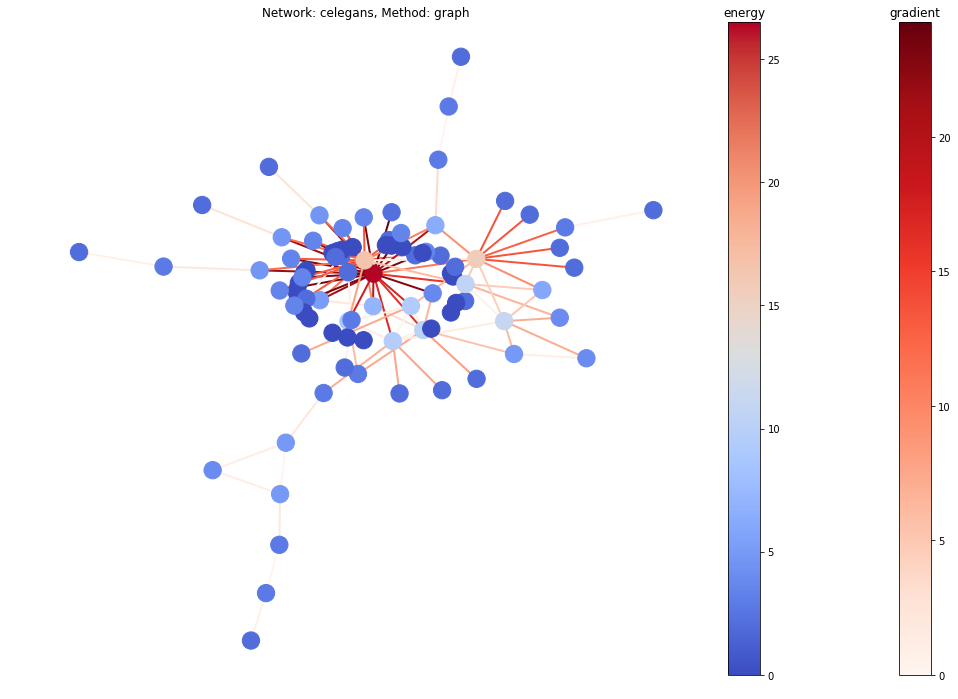

In [179]:
empirical_draw_network('celegans', 'graph', vstrategy='method+network')

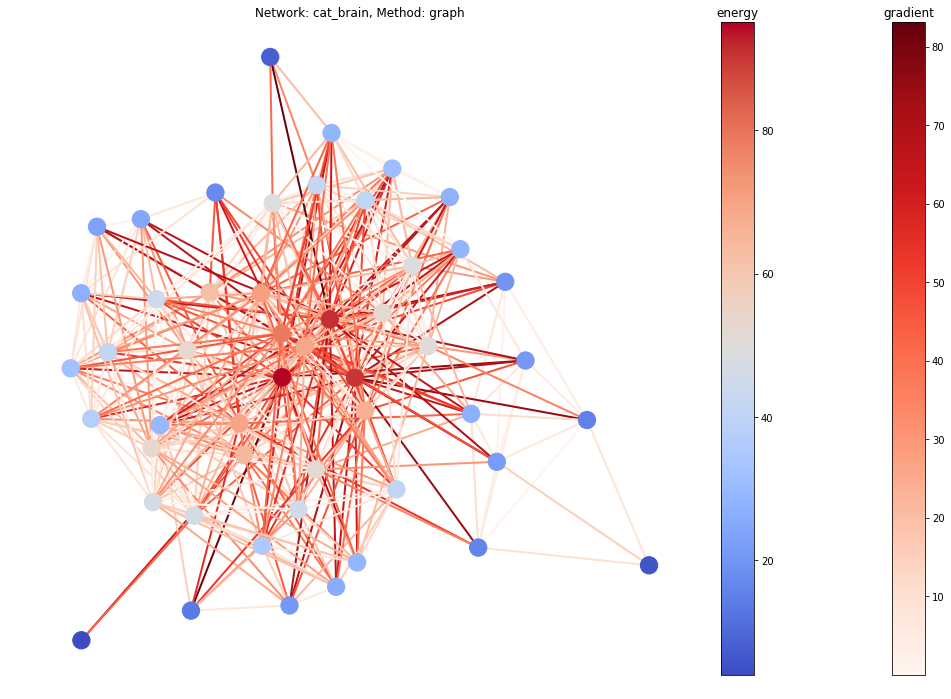

In [180]:
empirical_draw_network('cat_brain', 'graph', vstrategy='method+network')

### Visualization of laplacian energies and laplacian gradients

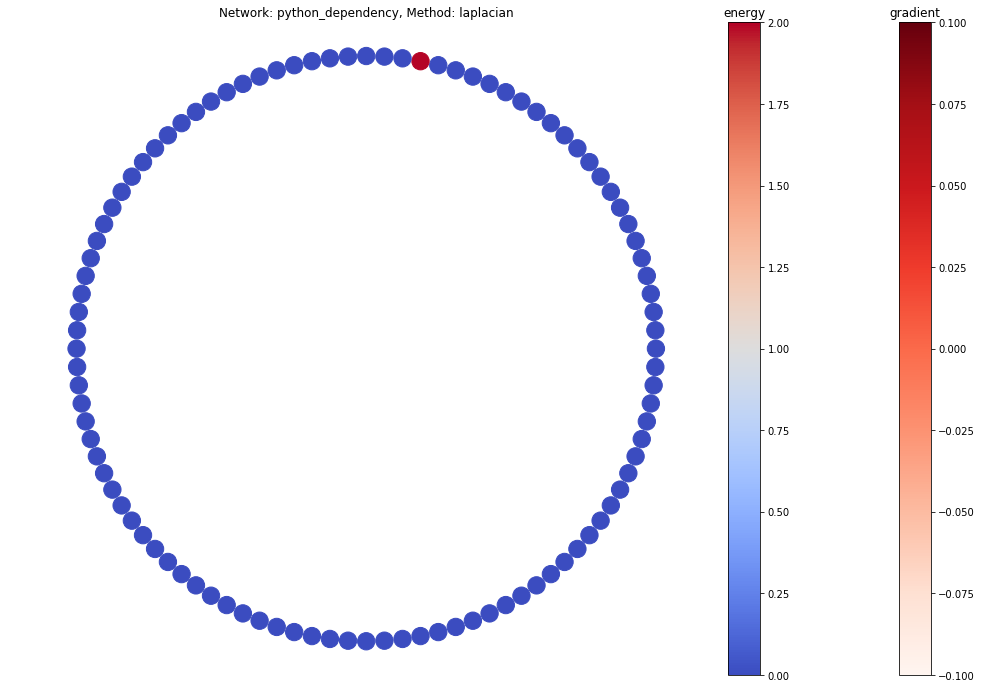

In [181]:
empirical_draw_network('python_dependency', 'laplacian', vstrategy='method+network')

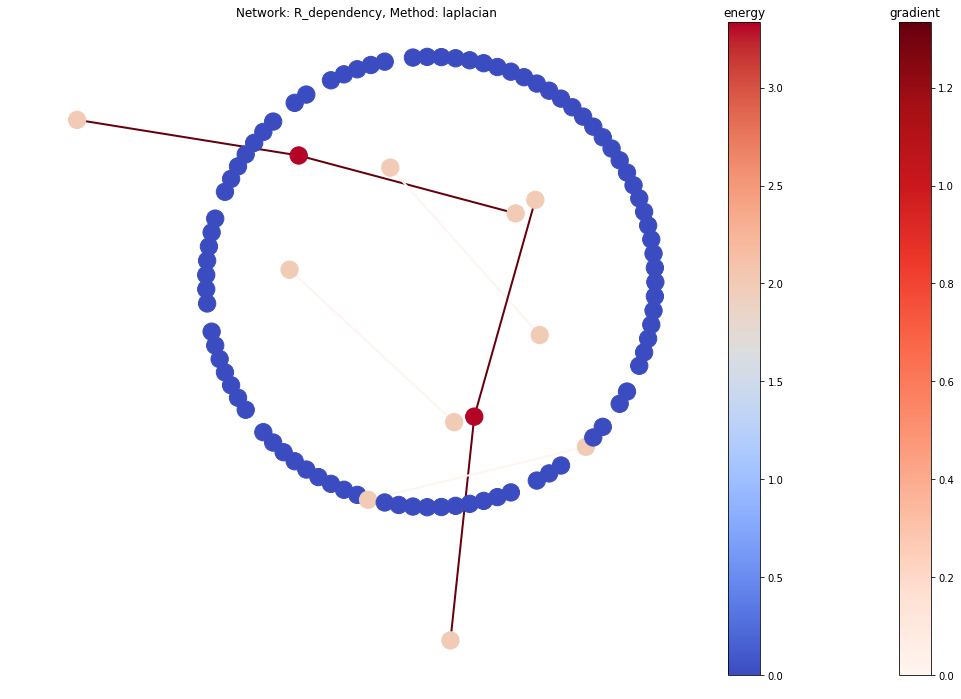

In [182]:
empirical_draw_network('R_dependency', 'laplacian', vstrategy='method+network')

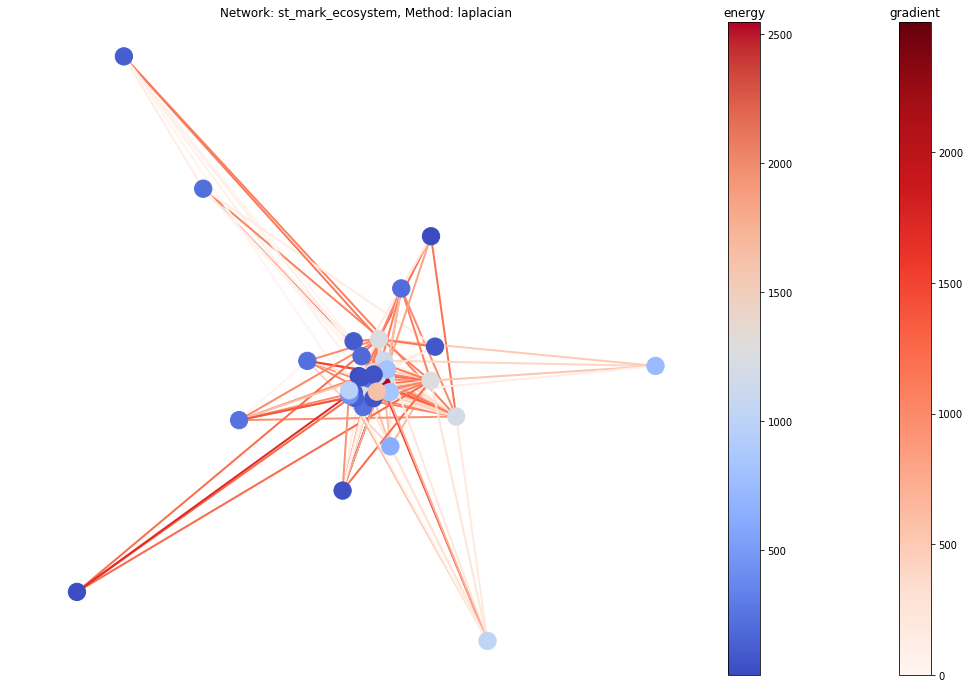

In [184]:
empirical_draw_network('st_mark_ecosystem', 'laplacian', vstrategy='method+network')

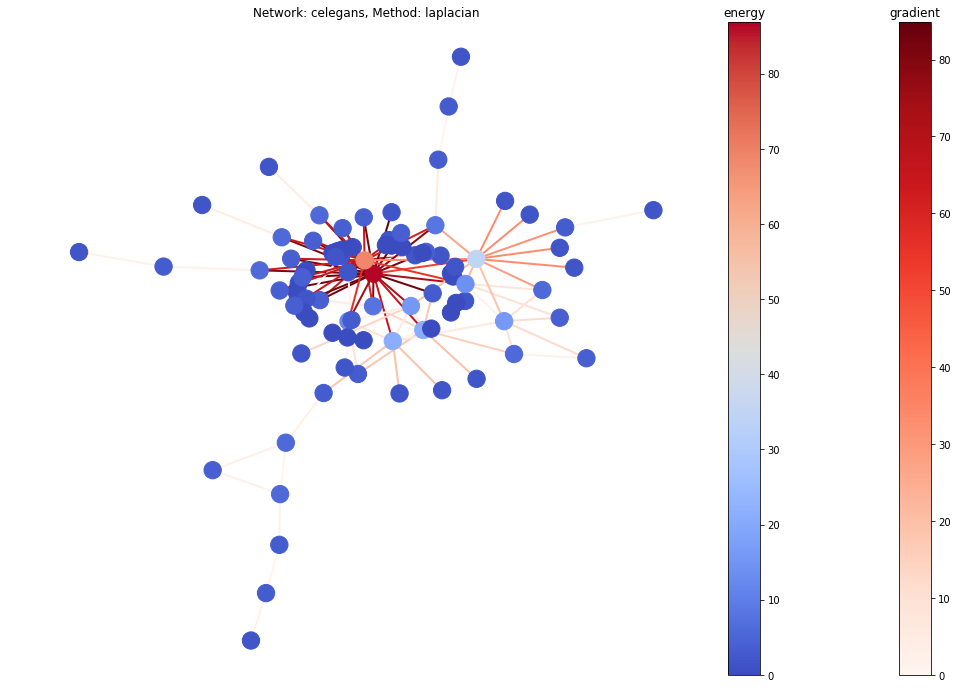

In [185]:
empirical_draw_network('celegans', 'laplacian', vstrategy='method+network')

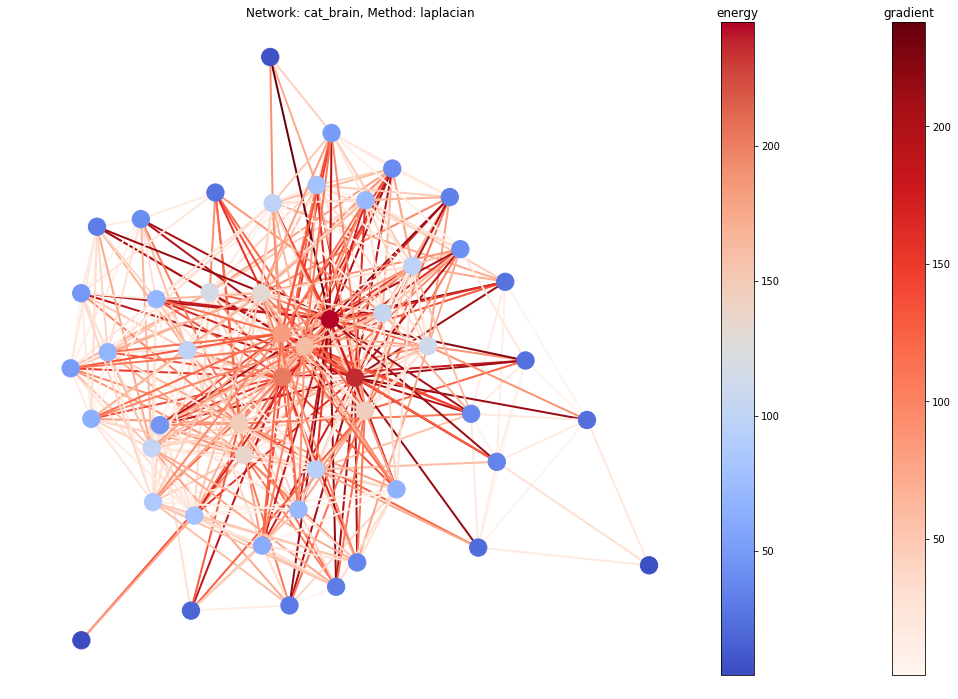

In [186]:
empirical_draw_network('cat_brain', 'laplacian', vstrategy='method+network')

### Visualization of randic energies and randic gradients

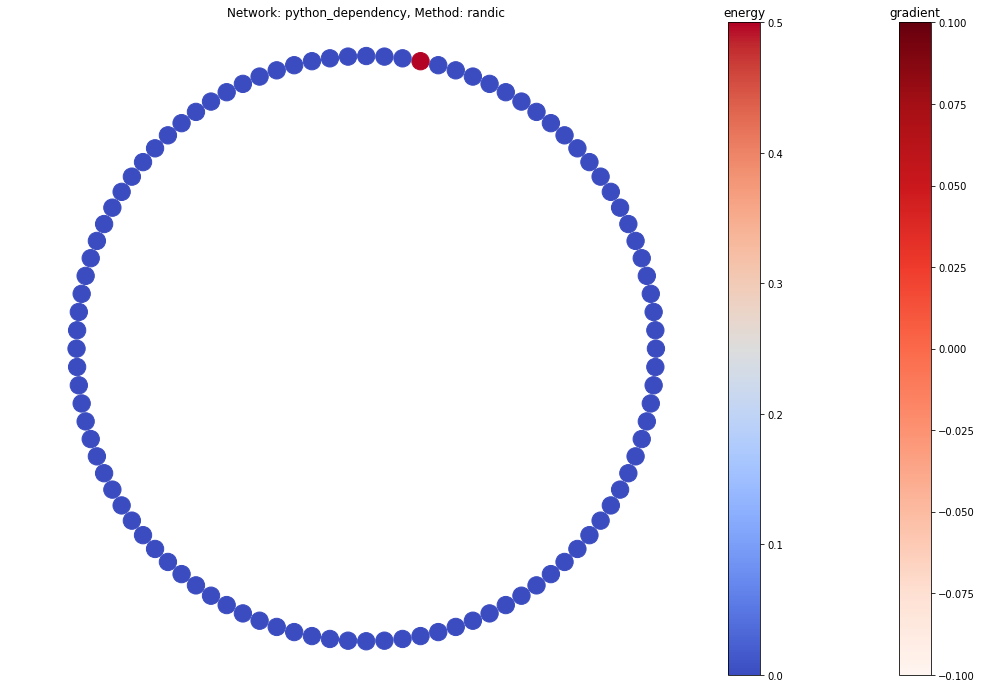

In [188]:
empirical_draw_network('python_dependency', 'randic', vstrategy='method+network')

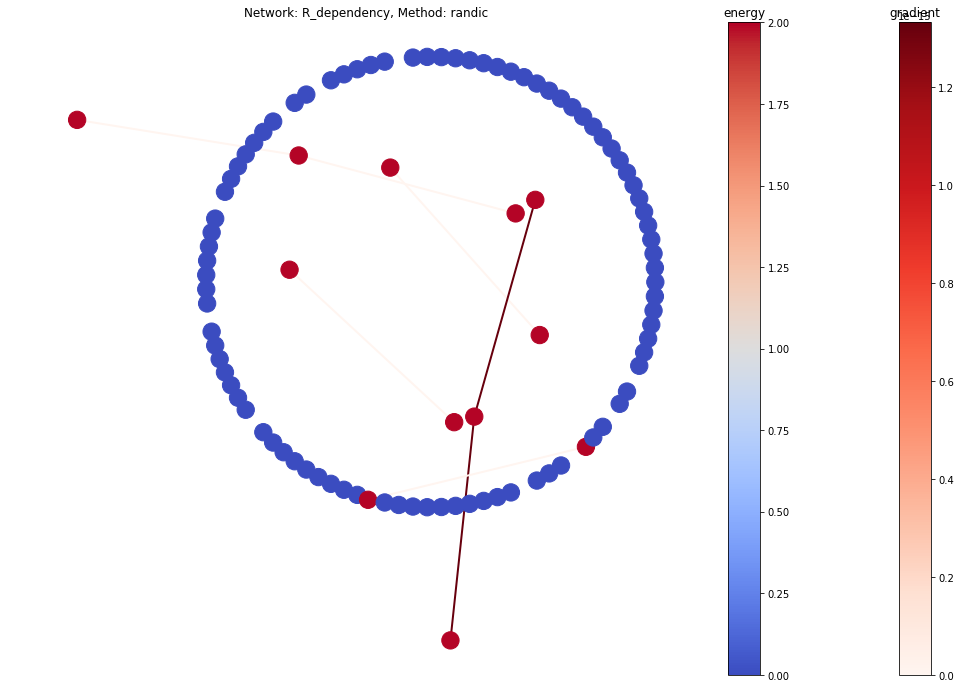

In [190]:
empirical_draw_network('R_dependency', 'randic', vstrategy='method+network')

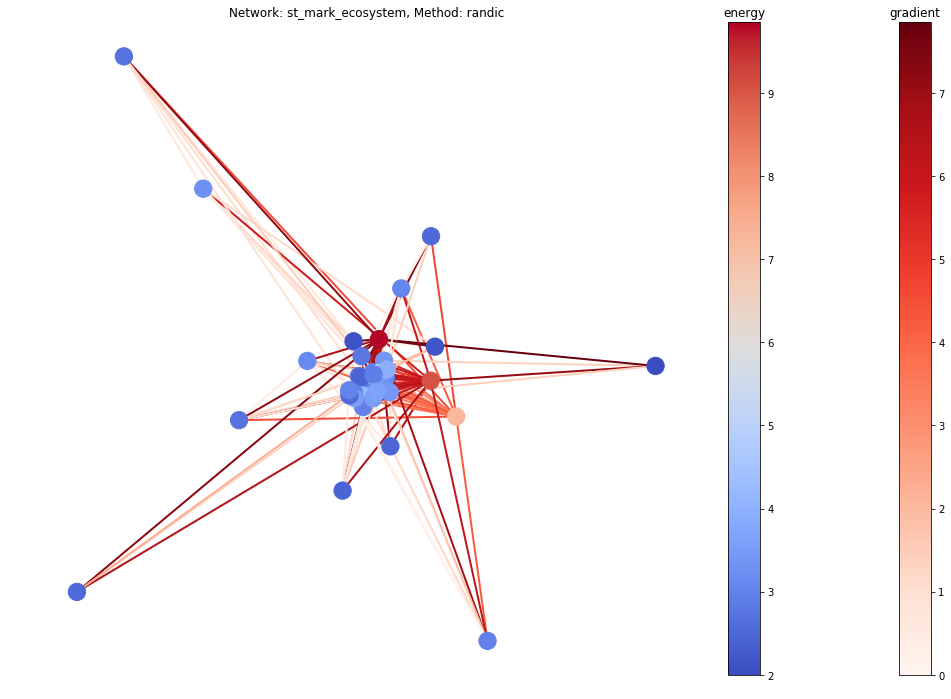

In [191]:
empirical_draw_network('st_mark_ecosystem', 'randic', vstrategy='method+network')

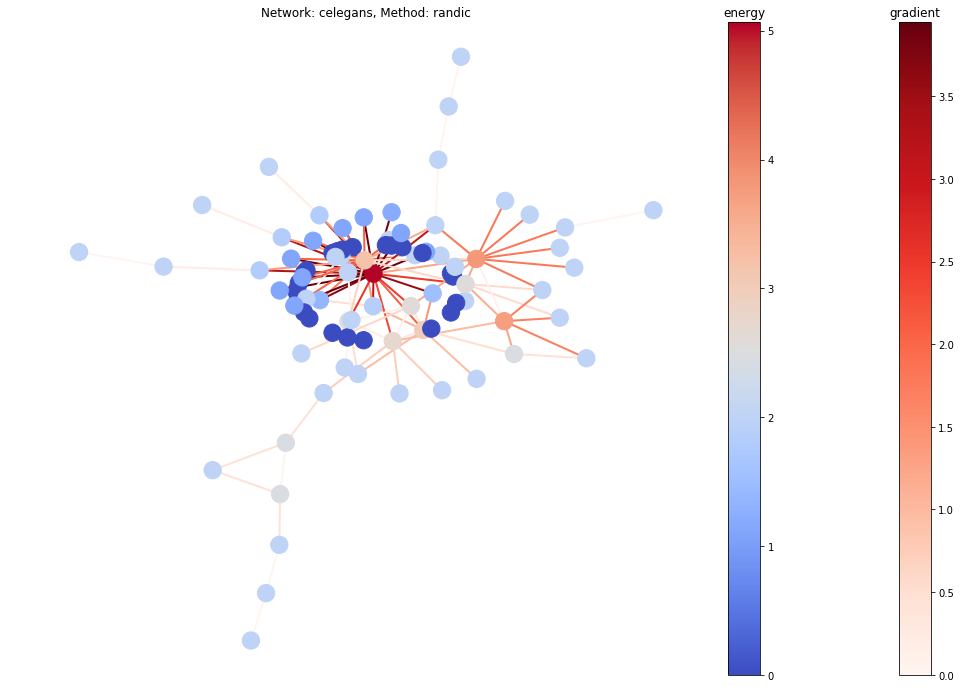

In [192]:
empirical_draw_network('celegans', 'randic', vstrategy='method+network')

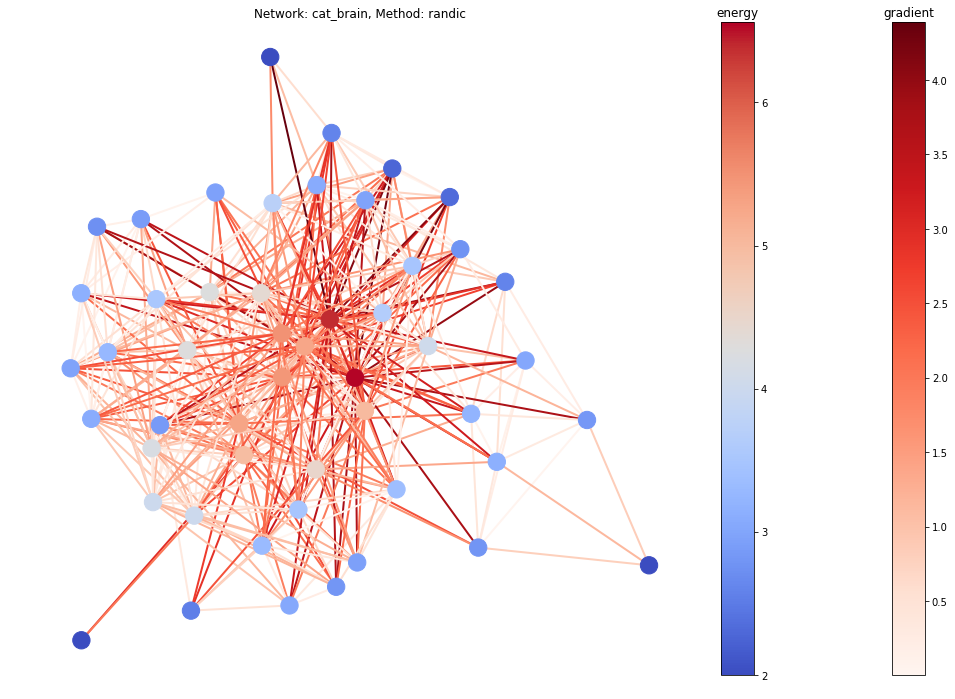

In [187]:
empirical_draw_network('cat_brain', 'randic', vstrategy='method+network')